In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import overpass
import requests
from osmtogeojson import osmtogeojson
import folium
from geopy import distance

from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon, shape
from geopy.geocoders import Nominatim

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [3]:
train = pd.read_csv('data/mf_geo_train.csv')
test = pd.read_csv('data/mf_geo_test.csv')

In [4]:
train.head(2)

point_id        lon        lat    target
0  ommNZCUV  37.590776  55.848630 -0.348157
1  nMe2LHPb  37.784210  55.750271  1.294206

In [5]:
test.head(2)

point_id        lon       lat  target
0  F4lXR1cG  37.681242  55.74804  0.0091
1  4LJu4GTf  60.580910  56.79586  0.0091

In [6]:
test['region'] = 'unknown'
train['region'] = 'unknown'

In [7]:
geolocator = Nominatim(user_agent="app_name")
for i in train.index:
    location = geolocator.reverse(f"{train['lat'][i]}, {train['lon'][i]}", language="ru")
    train['region'][i] = location.address.split(', ')[-4]
for j in test.index:
    location = geolocator.reverse(f"{test['lat'][j]}, {test['lon'][j]}", language="ru")
    test['region'][j] = location.address.split(', ')[-4]

### Geo

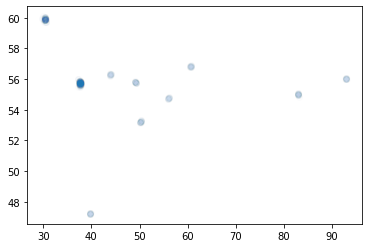

In [8]:
plt.scatter(train.lon, train.lat, alpha=.01)

In [9]:
geo_train = gpd.GeoDataFrame(
    train, geometry=gpd.points_from_xy(train.lon, train.lat))

In [10]:
geo_test = gpd.GeoDataFrame(
    test, geometry=gpd.points_from_xy(test.lon, test.lat))

In [11]:
geo_train.set_crs(epsg=4326, inplace=True)
geo_train = geo_train.to_crs(epsg=3857)

In [12]:
geo_test.set_crs(epsg=4326, inplace=True)
# geo_test = geo_train.to_crs(epsg=3857)

point_id        lon        lat  target                region  \
0    F4lXR1cG  37.681242  55.748040  0.0091                Москва   
1    4LJu4GTf  60.580910  56.795860  0.0091  Свердловская область   
2    kLuAAN3s  37.598614  55.781357  0.0091                Москва   
3    OxQHvaNu  37.794051  55.717468  0.0091                Москва   
4    paQsTa1K  49.213026  55.748290  0.0091             Татарстан   
..        ...        ...        ...     ...                   ...   
102  y8oQuX5v  30.353777  60.049792  0.0091       Санкт-Петербург   
103  4nmfqUw0  92.928927  56.116262  0.0091     Красноярский край   
104  N9O45mAh  93.015993  56.023697  0.0091     Красноярский край   
105  h2InCLKa  30.381172  59.871149  0.0091       Санкт-Петербург   
106  TQKiIgFt  30.279244  59.942110  0.0091       Санкт-Петербург   

                      geometry  
0    POINT (37.68124 55.74804)  
1    POINT (60.58091 56.79586)  
2    POINT (37.59861 55.78136)  
3    POINT (37.79405 55.71747)  
4    POINT (49.21303 55.74829)  
..                         ...  
102  POINT (30.35378 60.04979)  
103  POINT (92.92893 56.11626)  
104  POINT (93.01599 56.02370)  
105  POINT (30.38117 59.87115)  
106  POINT (30.27924 59.94211)  

[107 rows x 6 columns]

Посмотрим на распределение салонов на карте России

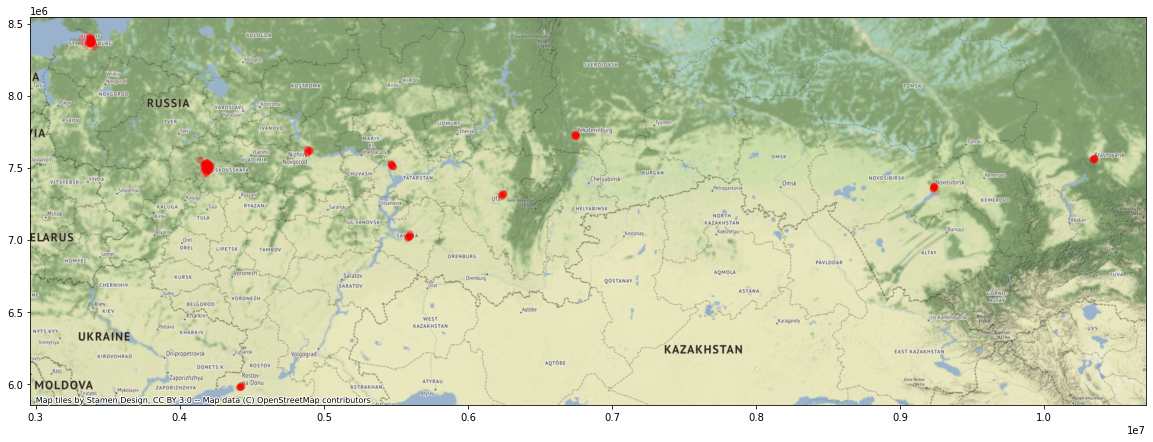

In [13]:
plot = geo_train.plot(color='red', alpha=0.1, figsize=(20, 25))
ctx.add_basemap(plot)

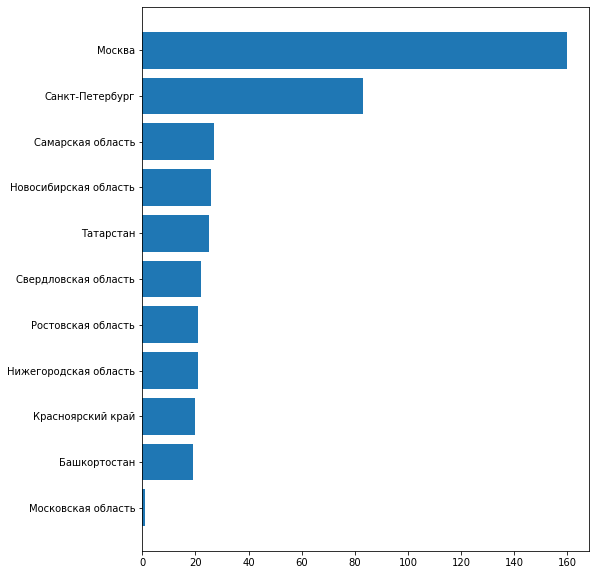

In [17]:
region_count = (
    train['region'].value_counts()
    .to_frame()
    .reset_index()
)
fig, ax = plt.subplots(figsize=(8,10))

ax.barh(region_count['index'], region_count['region'])
ax.invert_yaxis();

In [18]:
train['region'].unique()

array(['Москва', 'Ростовская область', 'Красноярский край',
       'Санкт-Петербург', 'Башкортостан', 'Татарстан',
       'Свердловская область', 'Нижегородская область',
       'Новосибирская область', 'Самарская область', 'Московская область'],
      dtype=object)

In [19]:
train['region'][train.region == 'Московская область'] = 'Москва'

In [20]:
test['region'][test.region == 'Московская область'] = 'Москва'

Нарисуем 3 карты городов с наибольшим количеством салонов

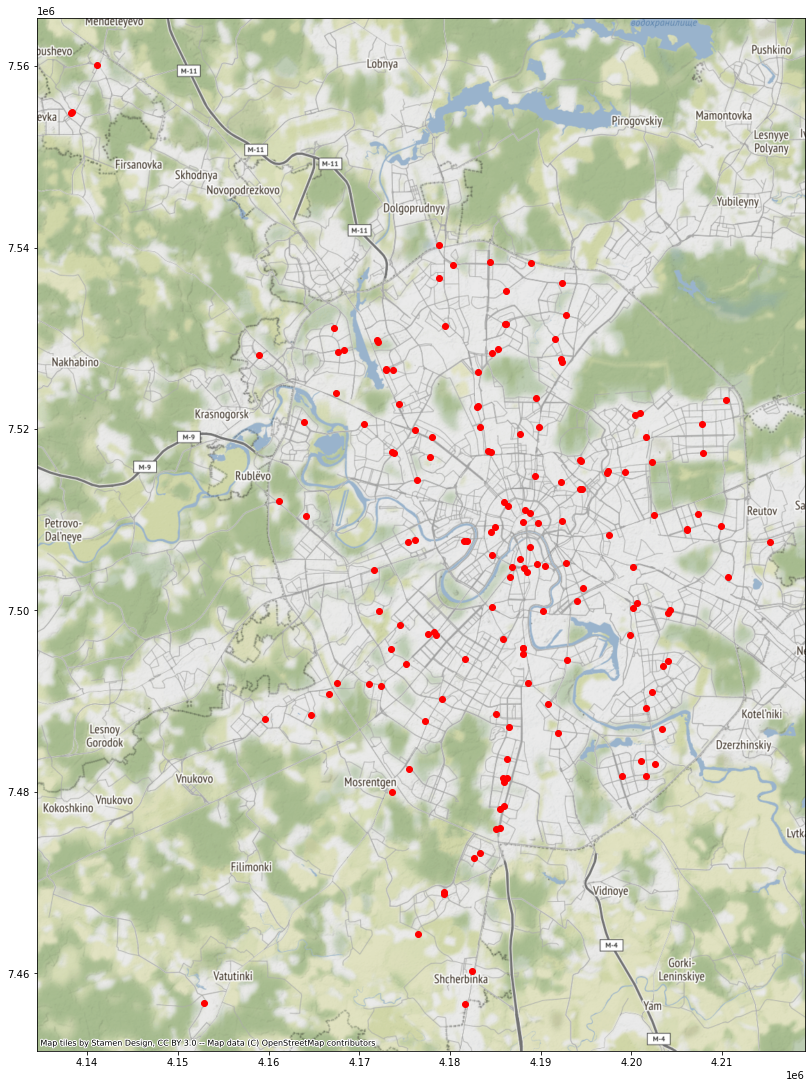

In [21]:
plot = geo_train[geo_train.region=='Москва'].plot(color='red', figsize=(20, 19))
ctx.add_basemap(plot)

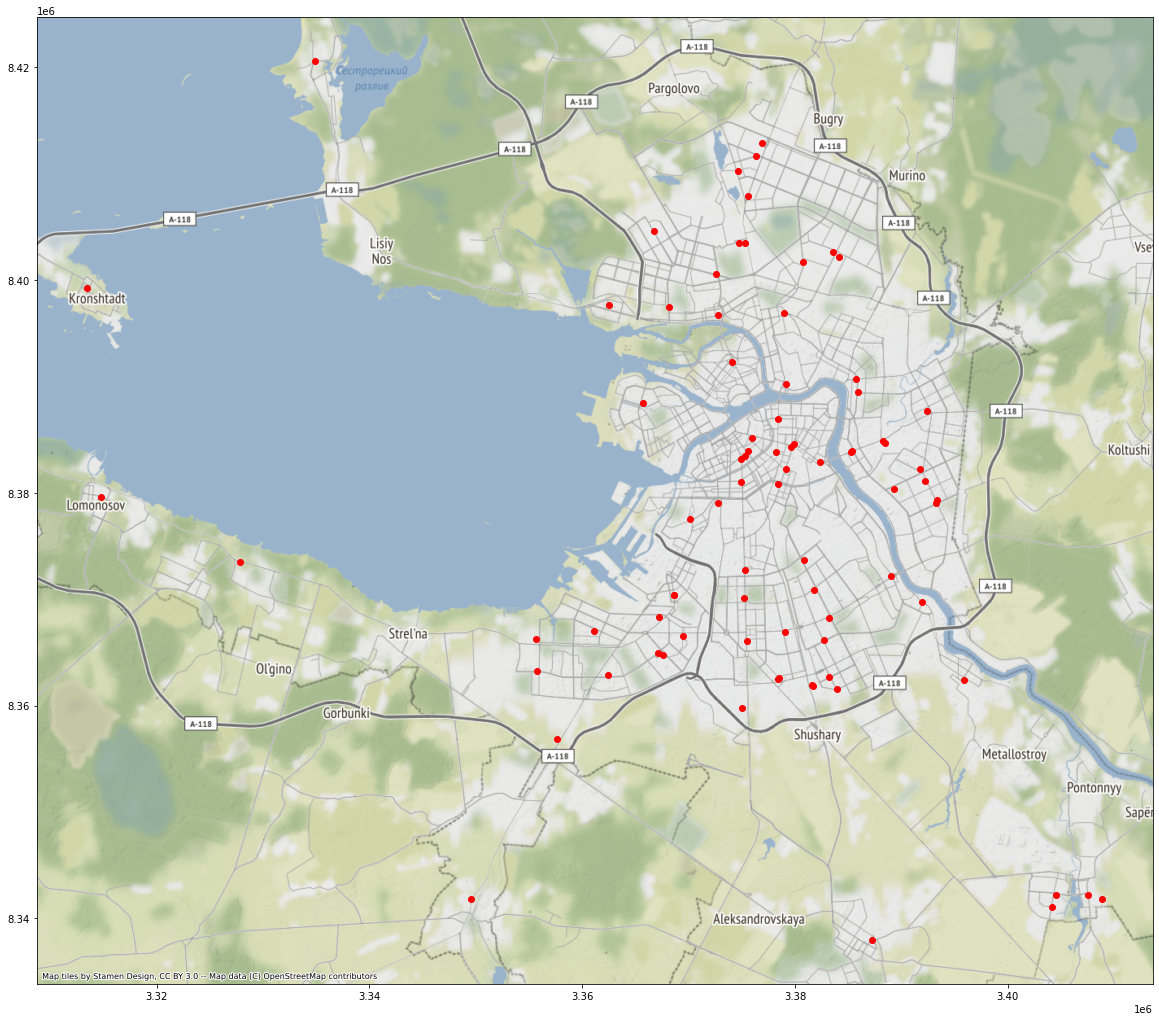

In [22]:
plot = geo_train[geo_train.region=='Санкт-Петербург'].plot(color='red', figsize=(20, 19))
ctx.add_basemap(plot)

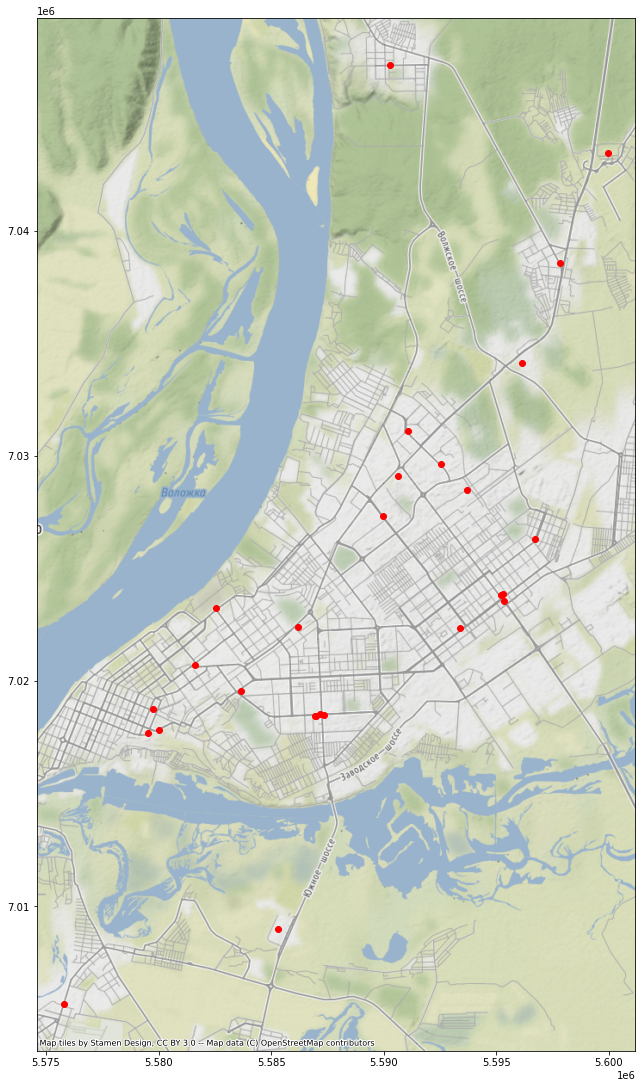

In [23]:
plot = geo_train[geo_train.region=='Самарская область'].plot(color='red', figsize=(20, 19))
ctx.add_basemap(plot)

Определим колонку с именем города, это нужно для запросов к osm, в частности чтобы определить железнодорожную станцию - городской вокзал, а не просто маленькие железнодорожные станции

In [24]:
def define_city_name(region):
    if region == 'Москва':
        return 'Москва'
    if region == 'Санкт-Петербург':
        return 'Санкт-Петербург'
    if region == 'Самарская область':
        return 'Самара'
    if region == 'Новосибирская область':
        return 'Новосибирск'
    if region == 'Татарстан':
        return 'Казань'
    if region == 'Свердловская область':
        return 'Екатеринбург'
    if region == 'Нижегородская область':
        return 'Нижний Новгород'
    if region == 'Ростовская область':
        return 'Ростов'
    if region == 'Красноярский край':
        return 'Красноярск'
    if region == 'Башкортостан':
        return 'Уфа'
    return None

In [25]:
train['city'] = None
for i in train.index:
    train['city'][i] = define_city_name(train.region[i])

In [26]:
test['city'] = None
for i in test.index:
    test['city'][i] = define_city_name(test.region[i])

In [27]:
train[train.region != 'Москва'].head(10)

point_id        lon        lat    target                 region  \
2   ZgodVRqB  39.635721  47.213330 -1.039679     Ростовская область   
5   ci9r9Fr2  92.926002  56.065908 -0.218497      Красноярский край   
6   O3tOF6uE  30.468500  59.921400 -1.039679        Санкт-Петербург   
8   GU0QclY1  92.903162  56.050290 -0.304937      Красноярский край   
9   CHtHXJLp  39.701709  47.234012 -0.132057     Ростовская область   
10  sgrEW5hG  39.716987  47.222272 -1.212559     Ростовская область   
12  1ZvdVY5t  55.993548  54.713414 -0.348157           Башкортостан   
13  zRh8HUje  49.118586  55.829578  0.040823              Татарстан   
16  9BqGtCOu  60.616914  56.848247 -0.175277   Свердловская область   
17  53eoFG4u  43.863684  56.228005  0.645905  Нижегородская область   

                     geometry             city  
2   POINT (39.63572 47.21333)           Ростов  
5   POINT (92.92600 56.06591)       Красноярск  
6   POINT (30.46850 59.92140)  Санкт-Петербург  
8   POINT (92.90316 56.05029)       Красноярск  
9   POINT (39.70171 47.23401)           Ростов  
10  POINT (39.71699 47.22227)           Ростов  
12  POINT (55.99355 54.71341)              Уфа  
13  POINT (49.11859 55.82958)           Казань  
16  POINT (60.61691 56.84825)     Екатеринбург  
17  POINT (43.86368 56.22801)  Нижний Новгород

In [28]:
# query = """
# [out:json][timeout:100];
# (area[name="Нижегородская область"];)->.a;
# nwr(area.a)["aeroway"="aerodrome"]["aerodrome"="international"];
# out geom;
# >;
# out skel qt;
# """

# url = "http://overpass-api.de/api/interpreter"
# r = requests.get(url, params={'data': query})

# res = osmtogeojson.process_osm_json(r.json())

In [29]:
# region = 'Нижегородская область'
# api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter", timeout=100)
# res2 = api.get(f'(area[name="{region}"];)->.a;nwr(area.a)["aeroway"="aerodrome"]["aerodrome"="international"];nwr(area.a)["aeroway"="aerodrome"]["aerodrome:type"="international"];', verbosity='geom')


Данные заполены по разному, поэтому красивого решения для выгрузки данных для разных городов я не нашла и использую условия на название региона, чтобы выгрузить все необходимые данные

In [30]:
def getData(df):
    responses = []
    for i in df[['region', 'city']].drop_duplicates().index:
        tmp = {}
        name=df.city[i]
        region=df.region[i]
        api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter", timeout=100)
        tmp['region'] = region

        if (region == 'Нижегородская область' or region == 'Ростовская область'):
            api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter", timeout=100)
            tmp['train_station'] = api.get(f'area[name="{region}"];node(area)["railway"="station"]["name"~"{name}"];', verbosity='geom')
        else:
            tmp['train_station'] = api.get(f'area[name="{region}"];node(area)["railway"="station"]["name"~"{name}"]["name:en"];', verbosity='geom')

        if (region == 'Москва'):
            region = 'Московская область'
            query = """
            [out:json][timeout:100];
            (area[name="Московская область"]; area[name="Москва"];)->.a;
            nwr(area.a)["aeroway"="aerodrome"]["aerodrome"="international"];
            out geom;
            >;
            out skel qt;
            """

            url = "http://overpass-api.de/api/interpreter"
            r = requests.get(url, params={'data': query})

            tmp['airports'] = osmtogeojson.process_osm_json(r.json())

        if (region == 'Санкт-Петербург'):
            region = 'Ленинградская область'
            query = """
            [out:json][timeout:100];
            (area[name~"Санкт-Петербург"];)->.a;
            nwr(area.a)["aeroway"="aerodrome"]["aerodrome"="international"];
            nwr(area.a)["aeroway"="aerodrome"]["aerodrome:type"="international"];
            out geom;
            >;
            out skel qt;
            """

            url = "http://overpass-api.de/api/interpreter"
            r = requests.get(url, params={'data': query})

            tmp['airports'] = osmtogeojson.process_osm_json(r.json())

        if (region == 'Башкортостан'):
            query = """
            [out:json][timeout:100];
            (area[name="Башкортостан"];)->.a;
            nwr(area.a)["aeroway"="aerodrome"]["aerodrome:type"="international"];
            out geom;
            >;
            out skel qt;
            """

            url = "http://overpass-api.de/api/interpreter"
            r = requests.get(url, params={'data': query})

            tmp['airports'] = osmtogeojson.process_osm_json(r.json())

        if (region == 'Нижегородская область'):
            query = """
            [out:json][timeout:100];
            (area[name="Нижегородская область"];)->.a;
            nwr(area.a)["aeroway"="aerodrome"]["aerodrome"="international"];
            out geom;
            >;
            out skel qt;
            """

            url = "http://overpass-api.de/api/interpreter"
            r = requests.get(url, params={'data': query})

            tmp['airports'] = osmtogeojson.process_osm_json(r.json())

        if (region == 'Новосибирская область'):
            query = """
            [out:json][timeout:100];
            (area[name="Новосибирская область"];)->.a;
            nwr(area.a)["aeroway"="aerodrome"]["aerodrome"="international"];
            out geom;
            >;
            out skel qt;
            """

            url = "http://overpass-api.de/api/interpreter"
            r = requests.get(url, params={'data': query})

            tmp['airports'] = osmtogeojson.process_osm_json(r.json())

        if (region == 'Красноярский край'):
            query = """
            [out:json][timeout:100];
            (area[name="Красноярский край"];)->.a;
            nwr(area.a)["aeroway"="aerodrome"]["name"~"Аэропорт Красноярск"];
            out geom;
            >;
            out skel qt;
            """

            url = "http://overpass-api.de/api/interpreter"
            r = requests.get(url, params={'data': query})

            tmp['airports'] = osmtogeojson.process_osm_json(r.json())

        if (region != 'Башкортостан' and region != 'Московская область' and region != 'Ленинградская область' and region != 'Новосибирская область' and region != 'Красноярский край' and region != 'Нижегородская область'):
            api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter", timeout=100)
            tmp['airports'] = api.get(f'(area[name="{region}"];)->.a;nwr(area.a)["aeroway"="aerodrome"]["aerodrome"="international"];nwr(area.a)["aeroway"="aerodrome"]["aerodrome:type"="international"];', verbosity='geom')

        api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter", timeout=100)
        tmp['hotels'] = api.get(f'(area[name="{name}"];)->.a;node(area.a)["tourism"="hotel"];', verbosity='geom')
        api = overpass.API(endpoint="https://overpass.kumi.systems/api/interpreter", timeout=100)
        tmp['metro'] = api.get(f'(area[name="{name}"];)->.a;node(area.a)["railway"="station"]["station"="subway"];', verbosity='geom')
        responses.append(tmp)
    return responses


In [31]:
responses = getData(train)

In [ ]:
# test_responses = getData(test)

In [32]:
responses_df = pd.DataFrame(responses)
# test_responses_df = pd.DataFrame(test_responses)

In [35]:
columns = ['train_station', 'airports', 'hotels', 'metro']
for col in columns:
    exec(f'{col}_df = gpd.GeoDataFrame()')
    for reg in responses_df.region.values:
        tmp = gpd.GeoDataFrame(responses_df[responses_df['region'] == reg][col].values[0]['features'][::])
        tmp['region'] = reg
        exec(f'{col}_df = {col}_df.append(tmp, ignore_index=True)')

In [36]:
metro_df

type            id                   geometry  \
0    Feature  6.066047e+07  POINT (37.66155 55.88718)   
1    Feature  6.066047e+07  POINT (37.66418 55.86962)   
2    Feature  6.891680e+07  POINT (37.75100 55.78853)   
3    Feature  6.893701e+07  POINT (37.72136 55.78331)   
4    Feature  2.411583e+08  POINT (37.48342 55.73946)   
..       ...           ...                        ...   
343  Feature  4.420082e+08  POINT (50.17651 53.20027)   
344  Feature  4.420082e+08  POINT (50.16050 53.20281)   
345  Feature  4.420082e+08  POINT (50.14899 53.21192)   
346  Feature  3.779455e+09  POINT (50.13419 53.20958)   
347  Feature  6.986625e+09  POINT (50.26953 53.21129)   

                                            properties             region  
0    {'colour': 'orange', 'layer': '-1', 'name': 'М...             Москва  
1    {'colour': 'orange', 'layer': '-2', 'name': 'Б...             Москва  
2    {'colour': 'blue', 'layer': '-4', 'name': 'Пар...             Москва  
3    {'colour': 'blue', 'layer': '-4', 'name': 'Сем...             Москва  
4    {'colour': 'lightblue', 'name': 'Филёвский пар...             Москва  
..                                                 ...                ...  
343  {'name': 'Гагаринская', 'name:cs': 'Gagarinska...  Самарская область  
344  {'name': 'Московская', 'name:cs': 'Moskovskaja...  Самарская область  
345  {'name': 'Российская', 'name:cs': 'Rossijskaja...  Самарская область  
346  {'name': 'Алабинская', 'operator': 'Самарский ...  Самарская область  
347  {'name': 'Кировская', 'name:cs': 'Kirovskaja',...  Самарская область  

[348 rows x 5 columns]

In [37]:
for i in airports_df['geometry'].index:
    if type(airports_df['geometry'][i]) != LineString and type(airports_df['geometry'][i]) != Polygon:
        lst = airports_df['geometry'][i]['coordinates'][0]
        tmp = []
        for l in lst:
            l = tuple(l)
            tmp.append(l)
#         print(airports_df['geometry'][i])
        airports_df['geometry'][i] = Polygon(tmp)

Нарусуем карту Москвы, на которую нанесем все полученные географические объекты - вокзалы, станции метро, отели и аэропорты

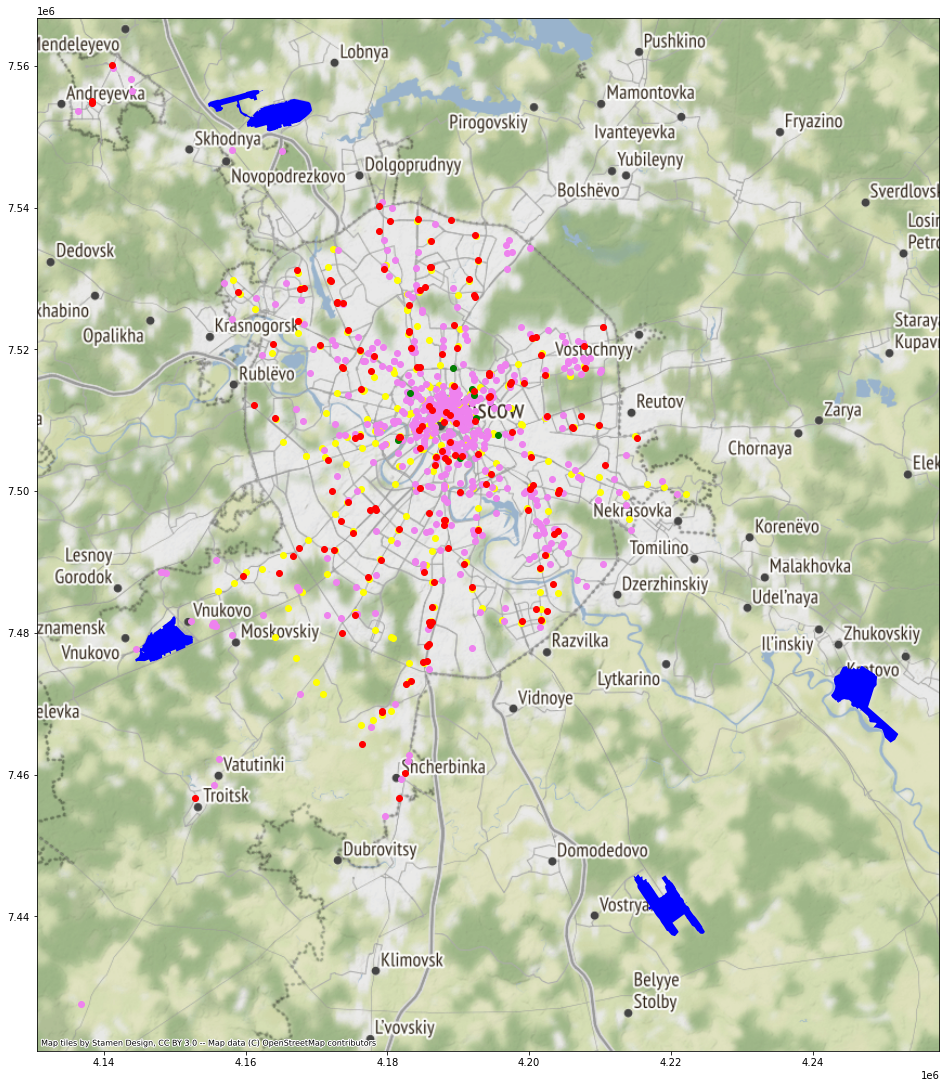

In [38]:
msk_airports = airports_df[airports_df['region'] == 'Москва']
msk_airports.set_crs(epsg=4326, inplace=True)
msk_airports = msk_airports.to_crs(epsg=3857)
msk_metro = metro_df[metro_df['region'] == 'Москва']
msk_metro.set_crs(epsg=4326, inplace=True)
msk_metro = msk_metro.to_crs(epsg=3857)
msk_hotels = hotels_df[hotels_df['region'] == 'Москва']
msk_hotels.set_crs(epsg=4326, inplace=True)
msk_hotels = msk_hotels.to_crs(epsg=3857)
msk_train_station = train_station_df[train_station_df['region'] == 'Москва']
msk_train_station.set_crs(epsg=4326, inplace=True)
msk_train_station = msk_train_station.to_crs(epsg=3857)
plot = msk_airports.plot(color='blue', figsize=(20, 19))
msk_metro.plot(color='yellow', ax=plot)
msk_hotels.plot(color='violet', ax=plot)
msk_train_station.plot(color='green', ax=plot)
geo_train[geo_train.region=='Москва'].plot(color='red', ax=plot)
ctx.add_basemap(plot)


In [39]:
from functools import partial
import pyproj
from shapely.ops import transform

proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')

def geodesic_point_buffer(lon, lat, m):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lon=lon, lat=lat)),
        proj_wgs84)
    buf = Point(0, 0).buffer(m)
    return transform(project, buf)

In [40]:
geo_train[['lon', 'lat']]
#     print(x)

lon        lat
0    37.590776  55.848630
1    37.784210  55.750271
2    39.635721  47.213330
3    37.704570  55.782020
4    37.643983  55.730188
..         ...        ...
420  37.628765  55.740664
421  37.586825  55.794233
422  37.678790  55.772910
423  37.752130  55.619640
424  37.705770  55.782950

[425 rows x 2 columns]

In [41]:
# msk_geodesic_buffers = gpd.GeoDataFrame()

# msk_geodesic_buffers['geometry'] = gpd.GeoDataFrame(
#     geometry=Polygon([Point(

p = [geodesic_point_buffer(geo_train['lon'][x], geo_train['lat'][x], 500) for x in geo_train[geo_train.region == 'Москва'].index]



In [42]:
msk_geodesic_buffers = gpd.GeoDataFrame(geometry = p)

In [43]:
msk_geodesic_buffers.set_crs(epsg=4326, inplace=True)
msk_geodesic_buffers = msk_geodesic_buffers.to_crs(epsg=3857)

Нарисуем интерактивную карту москвы, на которую также нанесем все объекты, только метки, соответствующие салонам, заменим на буферные зоны - можем визуально посмотреть, сколько объетов пападает в буферную зону. Была выбрана буферная зона в 500 м, так как это расстояние которое можно без труда пройти пешком, не планируя поход или поездку

In [44]:
m = folium.Map(
    location=[55.75370903771494, 37.61981338262558],
    tiles="cartodbpositron",
    zoom_start=12,
)

folium.GeoJson(msk_geodesic_buffers, name="geojson").add_to(m)
folium.GeoJson(msk_airports).add_to(m)
folium.GeoJson(msk_train_station, marker=folium.Marker(icon=folium.Icon(icon='train', prefix='fa', color='green', icon_color='#fff'))).add_to(m)
folium.GeoJson(msk_metro, marker=folium.Marker(icon=folium.Icon(icon='subway', prefix='fa', color='red', icon_color='#fff'))).add_to(m)
folium.GeoJson(msk_hotels, marker=folium.Marker(icon=folium.Icon(icon='hotel', prefix='fa', color='black', icon_color='#fff'))).add_to(m)

folium.LayerControl().add_to(m)
m

In [45]:
airports_center = [[airports_df['geometry'][i].centroid, airports_df['region'][i]] for i in airports_df.index]

In [46]:
airports_center_df = gpd.GeoDataFrame(airports_center, columns=['geometry', 'region'])

In [47]:
airports_center_df

geometry                 region
0   POINT (37.26656 55.59718)                 Москва
1   POINT (37.90467 55.40842)                 Москва
2   POINT (38.14960 55.55949)                 Москва
3   POINT (37.40024 55.97560)                 Москва
4   POINT (39.92570 47.49297)     Ростовская область
5   POINT (92.48208 56.17780)      Красноярский край
6   POINT (30.26532 59.80208)        Санкт-Петербург
7   POINT (55.88054 54.55526)           Башкортостан
8   POINT (49.27840 55.60950)              Татарстан
9   POINT (60.80672 56.74448)   Свердловская область
10  POINT (43.78544 56.22501)  Нижегородская область
11  POINT (82.64228 55.01604)  Новосибирская область
12  POINT (50.16254 53.50469)      Самарская область

In [48]:
metro_df = metro_df.set_crs(epsg=4326, inplace=True)
hotels_df = hotels_df.set_crs(epsg=4326, inplace=True)
train_station_df = train_station_df.set_crs(epsg=4326, inplace=True)
airports_center_df = airports_center_df.set_crs(epsg=4326, inplace=True)

In [49]:
train_station_df

type          id                   geometry  \
0   Feature    61088523  POINT (37.66218 55.75777)   
1   Feature    85698866  POINT (37.65991 55.77425)   
2   Feature   146573247  POINT (37.63213 55.79327)   
3   Feature   434499692  POINT (37.68931 55.74520)   
4   Feature   473887668  POINT (37.65676 55.77840)   
5   Feature  1705951317  POINT (37.64103 55.72910)   
6   Feature  2687590616  POINT (37.57786 55.77565)   
7   Feature  2687602339  POINT (37.56285 55.74200)   
8   Feature   778167843  POINT (39.74794 47.24482)   
9   Feature  1399125377  POINT (40.49006 47.90226)   
10  Feature  2012751849  POINT (39.61142 47.24838)   
11  Feature  6439711033  POINT (39.69038 47.21834)   
12  Feature  6836090142  POINT (40.75589 48.01985)   
13  Feature   276614459  POINT (93.10941 55.99762)   
14  Feature  2792164837  POINT (92.93315 56.07316)   
15  Feature  4535206674  POINT (92.82904 56.00590)   
16  Feature     7535181  POINT (30.35816 59.95818)   
17  Feature    21596808  POINT (30.36311 59.92693)   
18  Feature  2417778283  POINT (30.39276 59.89349)   
19  Feature  4288702580  POINT (30.41586 59.87549)   
20  Feature  4074554112  POINT (55.94818 54.74876)   
21  Feature  4795178533  POINT (49.09970 55.78863)   
22  Feature  4795178525  POINT (60.60606 56.85891)   
23  Feature  5691037820  POINT (43.94569 56.32216)   
24  Feature  8546851337  POINT (43.85425 56.28665)   
25  Feature   321521605  POINT (82.85453 54.99529)   
26  Feature  2005072395  POINT (82.95221 55.00449)   
27  Feature  2012878022  POINT (82.97414 55.06794)   
28  Feature  4008724786  POINT (82.89472 55.03594)   
29  Feature   457012018  POINT (50.12130 53.18568)   

                                           properties                 region  
0   {'express:user': '2000001', 'loc_name': 'Курск...                 Москва  
1   {'express:user': '2000003', 'loc_name': 'Казан...                 Москва  
2   {'esr:user': '196127', 'loc_name': 'Рижский во...                 Москва  
3   {'esr:user': '191547', 'express:user': '200125...                 Москва  
4   {'esr:user': '195506', 'loc_name': 'Ярославски...                 Москва  
5   {'esr:user': '193519', 'name': 'Москва-Пассажи...                 Москва  
6   {'esr:user': '198230', 'name': 'Москва-Пассажи...                 Москва  
7   {'esr:user': '198103', 'int_name': 'Moskva Kie...                 Москва  
8   {'alt_name': 'Ростов-Товарный', 'esr:user': '5...     Ростовская область  
9   {'name': 'Садки-Ростовские', 'railway': 'stati...     Ростовская область  
10  {'name': 'Ростов-Западный', 'railway': 'statio...     Ростовская область  
11  {'esr:user': '510204', 'name': 'Ростов-Главный...     Ростовская область  
12  {'esr:user': '589108', 'int_name': 'Chapaevka-...     Ростовская область  
13  {'esr:user': '890201', 'name': 'Красноярск-Вос...      Красноярский край  
14  {'esr:user': '890108', 'int_name': 'Krasnoyars...      Красноярский край  
15  {'esr:user': '890004', 'name': 'Красноярск-Пас...      Красноярский край  
16  {'addr:city': 'Санкт-Петербург', 'addr:housenu...        Санкт-Петербург  
17  {'esr:user': '031812', 'name': 'Санкт-Петербур...        Санкт-Петербург  
18  {'esr:user': '031808', 'name': 'Санкт-Петербур...        Санкт-Петербург  
19  {'esr:user': '030006', 'name': 'Санкт-Петербур...        Санкт-Петербург  
20  {'esr:user': '654504', 'int_name': 'Ufa', 'nam...           Башкортостан  
21  {'alt_name': 'Казань', 'alt_name:ru': 'Казань'...              Татарстан  
22  {'name': 'Екатеринбург-Пассажирский', 'name:en...   Свердловская область  
23  {'name': 'Нижний Новгород-Московский', 'old_na...  Нижегородская область  
24  {'esr:user': '260003', 'name': 'Нижний Новгоро...  Нижегородская область  
25  {'esr:user': '851207', 'name': 'Новосибирск-За...  Новосибирская область  
26  {'name': 'Новосибирск-Южный', 'name:de': 'Novo...  Новосибирская область  
27  {'name': 'Новосибирск-Восточный', 'name:de': '...  Новосибирская область  
28  {'esr:user': '850609', 'name': 'Новос

In [50]:
def calc_dist(df):
    dist = {}
    airports_min_dist = []
    metro_min_dist = []
    metro_count = []
    hotels_count = []
    train_min_dist = []
    for i in df.index:
        x = df.loc[i]
        point = (x['lat'], x['lon'])
        dists_metro = []
        dists_airport = []
        dists_train = []
        dists_hotels = []
        
        for j in metro_df.index:
#             if x['region'] == metro_df['region'][j]:
            metro = metro_df['geometry'][j]
            dists_metro.append(distance.geodesic((metro.y, metro.x), point).m)
        cnt_metro = len(list(filter(lambda x: x < 500, dists_metro)))
        min_dist = min(dists_metro) if dists_metro else None
        metro_min_dist.append(min_dist)
        metro_count.append(cnt_metro)
        
        for k in airports_center_df.index:
#             if x['region'] == airports_center_df['region'][k]:
            airport = airports_center_df['geometry'][k]
            dists_airport.append(distance.geodesic((airport.y, airport.x), point).m)
        min_dist_airport = min(dists_airport) if dists_airport else None
        airports_min_dist.append(min_dist_airport)
        
        for t in train_station_df.index:
#             if x['region'] == train_station_df['region'][t]:
            train = train_station_df['geometry'][t]
            dists_train.append(distance.geodesic((train.y, train.x), point).m)
        min_dist_train = min(dists_train) if dists_train else None
        train_min_dist.append(min_dist_train)
        
        for h in hotels_df.index:
#             if x['region'] == hotels_df['region'][h]:
            hotels = hotels_df['geometry'][h]
            dists_hotels.append(distance.geodesic((hotels.y, hotels.x), point).m)
        cnt_hotels = len(list(filter(lambda x: x < 500, dists_hotels)))
        hotels_count.append(cnt_hotels)
    
    dist['metro_min_dist'] = metro_min_dist
    dist['metro_count'] = metro_count
    dist['airports_min_dist'] = airports_min_dist
    dist['hotels_count'] = hotels_count
    dist['train_min_dist'] = train_min_dist
    return dist

In [59]:
d = calc_dist(geo_train)

In [54]:
d_test = calc_dist(geo_test)

In [74]:
ttrain = geo_train.copy()
ttest = geo_test.copy()

In [75]:
geo_train

point_id        lon        lat    target              region  \
0    ommNZCUV  37.590776  55.848630 -0.348157              Москва   
1    nMe2LHPb  37.784210  55.750271  1.294206              Москва   
2    ZgodVRqB  39.635721  47.213330 -1.039679  Ростовская область   
3    0t2jNYdz  37.704570  55.782020 -1.169339              Москва   
4    U27W4QJ7  37.643983  55.730188 -0.088837              Москва   
..        ...        ...        ...       ...                 ...   
420  AA8hN7bJ  37.628765  55.740664  0.213704              Москва   
421  uNw6t6xk  37.586825  55.794233 -0.002397              Москва   
422  Ap42ei8k  37.678790  55.772910 -0.910019              Москва   
423  rn9A8r62  37.752130  55.619640 -0.326547              Москва   
424  960M6jye  37.705770  55.782950 -1.234169              Москва   

                            geometry  
0    POINT (4184586.043 7528340.995)  
1    POINT (4206119.017 7508861.454)  
2    POINT (4412228.279 5976964.740)  
3    POINT (4197253.533 7515143.819)  
4    POINT (4190509.019 7504890.149)  
..                               ...  
420  POINT (4188814.959 7506961.467)  
421  POINT (4184146.220 7517561.842)  
422  POINT (4194383.717 7513340.645)  
423  POINT (4202547.888 7483066.376)  
424  POINT (4197387.116 7515327.921)  

[425 rows x 6 columns]

Рассчитала расстояния - расстояние до центра ближайщего аэропорта, расстояние до ближайщей станции метро, сколько станций метро попадает в буферную зону, сколько отелей попадает в буферную зону и расстояние до ближайшего вокзала

In [76]:
ttrain['airports_min_dist'] = d['airports_min_dist']
ttrain['metro_min_dist'] = d['metro_min_dist']
ttrain['metro_count'] = d['metro_count']
ttrain['airports_min_dist'] = d['airports_min_dist']
ttrain['hotels_count'] = d['hotels_count']
ttrain['train_min_dist'] = d['train_min_dist']

In [77]:
ttest['airports_min_dist'] = d_test['airports_min_dist']
ttest['metro_min_dist'] = d_test['metro_min_dist']
ttest['metro_count'] = d_test['metro_count']
ttest['airports_min_dist'] = d_test['airports_min_dist']
ttest['hotels_count'] = d_test['hotels_count']
ttest['train_min_dist'] = d_test['train_min_dist']

In [65]:
ttrain

point_id        lon        lat    target              region  \
0    ommNZCUV  37.590776  55.848630 -0.348157              Москва   
1    nMe2LHPb  37.784210  55.750271  1.294206              Москва   
2    ZgodVRqB  39.635721  47.213330 -1.039679  Ростовская область   
3    0t2jNYdz  37.704570  55.782020 -1.169339              Москва   
4    U27W4QJ7  37.643983  55.730188 -0.088837              Москва   
..        ...        ...        ...       ...                 ...   
420  AA8hN7bJ  37.628765  55.740664  0.213704              Москва   
421  uNw6t6xk  37.586825  55.794233 -0.002397              Москва   
422  Ap42ei8k  37.678790  55.772910 -0.910019              Москва   
423  rn9A8r62  37.752130  55.619640 -0.326547              Москва   
424  960M6jye  37.705770  55.782950 -1.234169              Москва   

                            geometry  airports_min_dist  metro_min_dist  \
0    POINT (4184586.043 7528340.995)       18488.298333      167.645587   
1    POINT (4206119.017 7508861.454)       31307.733723      176.020610   
2    POINT (4412228.279 5976964.740)       38034.263304   937740.803363   
3    POINT (4197253.533 7515143.819)       28763.417457       59.381043   
4    POINT (4190509.019 7504890.149)       27990.904301      387.420848   
..                               ...                ...             ...   
420  POINT (4188814.959 7506961.467)       27833.032300       87.814148   
421  POINT (4184146.220 7517561.842)       23325.955198      209.944632   
422  POINT (4194383.717 7513340.645)       28518.298646      113.996933   
423  POINT (4202547.888 7483066.376)       25414.076769      552.561144   
424  POINT (4197387.116 7515327.921)       28735.684103      185.428864   

     metro_count  hotels_count  train_min_dist  
0              1             2     6686.621061  
1              1             0     5986.403423  
2              0             0     4178.075624  
3              2             2     2932.717257  
4              2             4      221.826115  
..           ...           ...             ...  
420            3             6     1500.941530  
421            2             0     2144.263003  
422            1             6     1193.932269  
423            0             0    14048.643917  
424            2             2     3036.152873  

[425 rows x 11 columns]

### Fit model

In [78]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
le = preprocessing.LabelEncoder()
scaler = StandardScaler()
ttrain['region'] = le.fit_transform(ttrain['region'])

ttrain['airports_min_dist'] = scaler.fit_transform(ttrain['airports_min_dist'].values.reshape(-1,1))
ttrain['metro_min_dist'] = scaler.fit_transform(ttrain['metro_min_dist'].values.reshape(-1,1))
ttrain['train_min_dist'] = scaler.fit_transform(ttrain['train_min_dist'].values.reshape(-1,1))

ttest['region'] = le.fit_transform(ttest['region'])

ttest['airports_min_dist'] = scaler.fit_transform(ttest['airports_min_dist'].values.reshape(-1,1))
ttest['metro_min_dist'] = scaler.fit_transform(ttest['metro_min_dist'].values.reshape(-1,1))
ttest['train_min_dist'] = scaler.fit_transform(ttest['train_min_dist'].values.reshape(-1,1))

In [67]:
ttrain

point_id        lon        lat    target  region  \
0    ommNZCUV  37.590776  55.848630 -0.348157       2   
1    nMe2LHPb  37.784210  55.750271  1.294206       2   
2    ZgodVRqB  39.635721  47.213330 -1.039679       6   
3    0t2jNYdz  37.704570  55.782020 -1.169339       2   
4    U27W4QJ7  37.643983  55.730188 -0.088837       2   
..        ...        ...        ...       ...     ...   
420  AA8hN7bJ  37.628765  55.740664  0.213704       2   
421  uNw6t6xk  37.586825  55.794233 -0.002397       2   
422  Ap42ei8k  37.678790  55.772910 -0.910019       2   
423  rn9A8r62  37.752130  55.619640 -0.326547       2   
424  960M6jye  37.705770  55.782950 -1.234169       2   

                            geometry  airports_min_dist  metro_min_dist  \
0    POINT (4184586.043 7528340.995)          -0.426755       -0.450433   
1    POINT (4206119.017 7508861.454)           1.201109       -0.450399   
2    POINT (4412228.279 5976964.740)           2.055271        3.342940   
3    POINT (4197253.533 7515143.819)           0.878021       -0.450871   
4    POINT (4190509.019 7504890.149)           0.779925       -0.449543   
..                               ...                ...             ...   
420  POINT (4188814.959 7506961.467)           0.759877       -0.450756   
421  POINT (4184146.220 7517561.842)           0.187550       -0.450261   
422  POINT (4194383.717 7513340.645)           0.846895       -0.450650   
423  POINT (4202547.888 7483066.376)           0.452708       -0.448875   
424  POINT (4197387.116 7515327.921)           0.874500       -0.450361   

     metro_count  hotels_count  train_min_dist  
0              1             2       -0.046836  
1              1             0       -0.166150  
2              0             0       -0.474280  
3              2             2       -0.686482  
4              2             4       -1.148404  
..           ...           ...             ...  
420            3             6       -0.930450  
421            2             0       -0.820831  
422            1             6       -0.982763  
423            0             0        1.207615  
424            2             2       -0.668858  

[425 rows x 11 columns]

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(ttrain.drop(columns=['target', 'geometry', 'lon', 'lat'], axis=1), ttrain[['target']])
model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [80]:
ttest = ttest.drop(columns=['target', 'city', 'geometry', 'lon', 'lat'], axis=1)

In [81]:
mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.6407315626191422

### Make submission

In [72]:
ttest

point_id  region             city  airports_min_dist  metro_min_dist  \
0    F4lXR1cG       2           Москва           1.057683       -0.455088   
1    4LJu4GTf       8     Екатеринбург          -1.049303       -0.446717   
2    kLuAAN3s       2           Москва           0.274680       -0.455073   
3    OxQHvaNu       2           Москва           0.743074       -0.455532   
4    paQsTa1K       9           Казань          -0.910835        0.724851   
..        ...     ...              ...                ...             ...   
102  y8oQuX5v       7  Санкт-Петербург           0.685517       -0.450996   
103  4nmfqUw0       1       Красноярск           0.760871        2.160005   
104  N9O45mAh       1       Красноярск           1.925295        2.177581   
105  h2InCLKa       7  Санкт-Петербург          -1.695273       -0.454592   
106  TQKiIgFt       7  Санкт-Петербург          -0.959897       -0.454742   

     metro_count  hotels_count  train_min_dist  
0              2             2       -1.241751  
1              0             0        0.086640  
2              2             1       -1.070050  
3              1             2        0.103028  
4              0             0        0.333533  
..           ...           ...             ...  
102            0             0        0.695767  
103            0             0       -0.393256  
104            0             0       -0.049907  
105            1             1       -0.958538  
106            1             9       -0.402736  

[107 rows x 8 columns]

In [82]:
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = model.predict(ttest.drop('point_id', axis=1))
submission.to_csv('data/my_submission_01.csv', index=False)